# The Search for Interesting Database

The idea of this project is to find an interesting db, that gives much better results on deep networks than on shallow ones, but that is not too "expensive" to use like imagenet, for example.

## Init

In [4]:
#Autocomplete
%config Completer.use_jedi = False

In [5]:
%matplotlib inline
%time

import numpy as np
import matplotlib.pyplot as plt
import os, time, glob
from tqdm.notebook import tqdm
import pandas as pd
from sklearn import svm
from tqdm.notebook import tqdm
from collections import namedtuple

Wall time: 0 ns


In [6]:
os.environ['KERAS_BACKEND'] = "tensorflow"

import keras
from keras import backend as K
from keras import models, layers
from keras.models import Sequential, Input, Model
from keras.layers import InputLayer, Dense, Conv2D, BatchNormalization, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras.initializers import glorot_normal, RandomNormal
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [8]:
# adding project's file
from visualization import visualize

## Datasets

### Fashion MNist

In [9]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [10]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [11]:
train_images_norm = train_images.astype("float32") / 255.0
test_images_norm = test_images.astype("float32") / 255.0

In [12]:
train_images_pad = np.zeros((train_images_norm.shape[0], 32, 32, 1), dtype=train_images_norm.dtype)
test_images_pad = np.zeros((test_images_norm.shape[0], 32, 32, 1), dtype=test_images_norm.dtype)
train_images_pad[:,2:30, 2:30, :] = train_images_norm
test_images_pad[:,2:30, 2:30, :] = test_images_norm

train_images_pad.shape, test_images_pad.shape

((60000, 32, 32, 1), (10000, 32, 32, 1))

In [19]:
def create_fmnist():
    fashion_mnist = tf.keras.datasets.fashion_mnist
    (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
    
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
    test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0
    
    train_images_pad = np.zeros((train_images.shape[0], 32, 32, 1), dtype=train_images.dtype)
    test_images_pad = np.zeros((test_images.shape[0], 32, 32, 1), dtype=test_images.dtype)
    train_images_pad[:,2:30, 2:30, :] = train_images
    test_images_pad[:,2:30, 2:30, :] = test_images
    
    return train_images_pad, train_labels, test_images_pad, test_labels

### Cifar10

In [23]:
def create_cifar():
    cifar = tf.keras.datasets.cifar10
    (train_images, train_labels), (test_images, test_labels) = cifar.load_data()
    
    train_images = train_images.astype("float32") / 255.0
    test_images = test_images.astype("float32") / 255.0
    
    train_labels = np.squeeze(train_labels)
    test_labels = np.squeeze(test_labels)

    return train_images, train_labels, test_images, test_labels

In [205]:
train_x,train_y,test_x,test_y = create_cifar()
train_x.shape, test_x.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

### Breast Cancer Data

Taken from here: https://www.kaggle.com/paultimothymooney/breast-histopathology-images

In [7]:
BC_LOCATION = r'D:\code\image_datasets\Breast_Cancer\IDC_regular_ps50_idx5'

def create_bcancer (location=BC_LOCATION, seed=0, limit_data=50000):
    """
    set limit_data to -1 in order not to limit the data size
    """
    
    image_patches = glob.glob(os.path.join(location, r'**/*.png'), recursive=True)
    data = np.zeros((0,50,50,3))
    labels = np.zeros((0,1))
    
    num_samples = len(image_patches)
    np.random.seed(seed)
    randperm = np.random.permutation(num_samples)
    
    for idx in tqdm(randperm[:limit_data]):
        try:
            f = image_patches[idx]
            img = np.reshape(plt.imread(f), (1,50,50,3))
        except ValueError:
            continue # edge patches with unorthodox size
        data = np.append(data, img, axis=0)
        if f.endswith("class0.png"):
            labels = np.append(labels, [0])
        else:
            labels = np.append(labels, [1])
            
    # Split to train and test
    num_samples = labels.size
    train_x = data[:(num_samples*4//5), :, :, :]
    train_y = labels[:(num_samples*4//5)]
    test_x = data[(num_samples*4//5):, :, :, :]
    test_y = labels[(num_samples*4//5):]
    
    return train_x, train_y, test_x, test_y

In [15]:
%%time

# verify breast_cancer dataset
bc_train_x,bc_train_y,bc_test_x,bc_test_y = create_bcancer()
bc_train_x.shape, bc_train_y.shape, bc_test_x.shape, bc_test_y.shape, bc_train_y.sum(), bc_test_y.sum()

  0%|          | 0/50000 [00:00<?, ?it/s]

Wall time: 10h 6min 10s


((39652, 50, 50, 3), (39652,), (9913, 50, 50, 3), (9913,), 11341.0, 2823.0)

## Neural Networks

### LeNet

In [8]:
def create_lenet(input_shape):
    lenet = keras.Sequential()

    lenet.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    lenet.add(layers.AveragePooling2D())
    lenet.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    lenet.add(layers.AveragePooling2D())
    lenet.add(layers.Flatten())
    lenet.add(layers.Dense(units=120, activation='relu'))
    lenet.add(layers.Dense(units=84, activation='relu'))
    lenet.add(layers.Dense(units=10, activation = 'softmax'))
    
    return lenet

In [16]:
input_shape=(28,28,1)
input_shape_pad=(32,32,1)

In [237]:
lenet = create_lenet(input_shape)
lenet.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 26, 26, 6)         60        
_________________________________________________________________
average_pooling2d_32 (Averag (None, 13, 13, 6)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 11, 11, 16)        880       
_________________________________________________________________
average_pooling2d_33 (Averag (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 400)               0         
_________________________________________________________________
dense_52 (Dense)             (None, 120)               48120     
_________________________________________________________________
dense_53 (Dense)             (None, 84)              

### MiniVGGNet

In [9]:
def create_minivgg(input_shape):
    minivgg = Sequential()
    # first CONV => RELU => CONV => RELU => POOL layer set
    minivgg.add(Conv2D(32, (3, 3), padding="same",
        input_shape=input_shape))
    minivgg.add(Activation("relu"))
    minivgg.add(BatchNormalization(axis=-1))
    minivgg.add(Conv2D(32, (3, 3), padding="same"))
    minivgg.add(Activation("relu"))
    minivgg.add(BatchNormalization(axis=-1))
    minivgg.add(MaxPooling2D(pool_size=(2, 2)))
    minivgg.add(Dropout(0.25))
    # second CONV => RELU => CONV => RELU => POOL layer set
    minivgg.add(Conv2D(64, (3, 3), padding="same"))
    minivgg.add(Activation("relu"))
    minivgg.add(BatchNormalization(axis=-1))
    minivgg.add(Conv2D(64, (3, 3), padding="same"))
    minivgg.add(Activation("relu"))
    minivgg.add(BatchNormalization(axis=-1))
    minivgg.add(MaxPooling2D(pool_size=(2, 2)))
    minivgg.add(Dropout(0.25))
    # first (and only) set of FC => RELU layers
    minivgg.add(Flatten())
    minivgg.add(Dense(512))
    minivgg.add(Activation("relu"))
    minivgg.add(BatchNormalization())
    minivgg.add(Dropout(0.5))
    # softmax classifier
    minivgg.add(Dense(10))
    minivgg.add(Activation("softmax"))
    
    return minivgg

In [20]:
minivgg = create_minivgg(input_shape)
minivgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)       

### MobileNetV2

In [10]:
def create_mobilenmetv2(input_shape):
    mobilenetv2 = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                include_top=True,
                                                weights=None,
                                                classes=10,
                                                classifier_activation="softmax")
    return mobilenetv2

In [22]:
mobilenetv2 = create_mobilenmetv2(input_shape_pad)
mobilenetv2.summary()

Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   288         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

### LeNet Kernel - Convolutional SVM

The idea of this model is to pre-train LeNet using MNist, and then run it as a kernel for SVM.

In [65]:
class Conv_SVM:
    def __init__ (self, input_shape=(32,32,1), location = r'D:\code\Daniely\Models\LeNetKer'):
        self.location = location
        self.input_shape = input_shape
        self._load_model()
        self.clf = None

    def _load_model(self):
        if not os.path.exists(self.location):
            mnist = tf.keras.datasets.mnist
            (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

            train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
            train_images_pad = np.zeros((train_images_norm.shape[0], 32, 32, 1), dtype=train_images_norm.dtype)
            train_images_pad[:,2:30, 2:30, :] = train_images

            init_lr = 1e-2
            num_epochs = 100
            lenet_model = create_lenet((32,32,1))
            opt = keras.optimizers.SGD(lr=init_lr, momentum=0.9, decay=init_lr / num_epochs)
            lenet_model.compile(optimizer=opt,
                                loss=keras.losses.sparse_categorical_crossentropy,
                                metrics=['accuracy'])

            model.history = lenet_model.fit(x=train_images_pad, y=train_labels,
                                            batch_size = 32, verbose=1, epochs=num_epochs)

            lenet_model.save(self.location)
        else:
            lenet_model = keras.models.load_model(self.location)
            
        # Update the model to the input shape
        input_shape = self.input_shape
        json = lenet_model.to_json()
        json = json.replace('"batch_input_shape": [null, 32, 32, 1]', '"batch_input_shape": [null, %d, %d, %d]'
                            %(input_shape[0],input_shape[1],input_shape[2]))
        crop_x = (input_shape[0]-2)//4-7
        crop_y = (input_shape[1]-2)//4-7
        json = json.replace('{"class_name": "Flatten",',
                            '{"class_name": "Cropping2D", "config": {"name": "cropping2d", "trainable": true, "dtype": "float32", "cropping": [[%d, %d], [%d, %d]], "data_format": "channels_last"}}, {"class_name": "Flatten",'
                           %(crop_x//2, crop_x-crop_x//2, crop_y//2, crop_y-crop_y//2))
        new_model = keras.models.model_from_json(json)
        
        # Update the weights
        new_weights = [K.repeat_elements(lenet_model.layers[0].weights[0], input_shape[2], 2).numpy(),
                      lenet_model.layers[0].weights[1].numpy()]
        new_model.layers[0].set_weights(new_weights)
        for layer in new_model.layers[1:]:
            try:
                layer.set_weights(lenet_model.get_layer(name=layer.name).get_weights())
            except ValueError: # for new added layer
                pass
        
        self.model = new_model
        
        
    def _map_to_feat_space(self, xdata):
        features = keras.Model(self.model.input, self.model.get_layer(index=-2).output)
        res = features.predict(xdata)
        return res
    
    def accuracy (self, x, y):
        if self.clf is None:
            raise Exception('Need to fit some data first')
        y_pred = self.clf.predict(x)
        return (y_pred == y).sum() / y.size
        
    def compile(self, **args):
        pass
    
    def fit(self, x, y, validation_data, **args):
        self.clf = svm.SVC(decision_function_shape='ovr')
        
        # instead of using smart kernel, we just map to the new feature space
        x_train_feat = self._map_to_feat_space(x)
        self.clf.fit(x_train_feat, y)
        
        x_test_feat = self._map_to_feat_space(validation_data[0])
        history = {'accuracy': [self.accuracy(x_train_feat, y)],
                   'val_accuracy': [self.accuracy(x_test_feat, validation_data[1])]}
        
        return namedtuple("History", "history")(history=history)

In [45]:
def create_convsvm(input_shape):
    if input_shape[0] < 32 or input_shape[1] < 32:
        raise Exception('Input edge must be at least 32, got %s'%input_shape[0])
    return Conv_SVM(input_shape)

In [328]:
trainx, trainy, testx, testy = create_fmnist()
csvm = evaluate_model('convsvm', trainx, trainy, testx, testy)
csvm

(History(history={'accuracy': [0.8441833333333333], 'val_accuracy': [0.8277]}),
 370.8115990161896)

## Usefull Functions

In [13]:
def evaluate_model(model_name, trainx, trainy, testx, testy, num_epochs=50):
    """
    model_name is either vgg, mobilenet, lenet, convsvm
    """
    
    init_lr = 1e-2
    input_shape = trainx.shape[1:]
    
    if model_name.lower() == 'lenet':
        model = create_lenet(input_shape)
    elif model_name.lower() == 'vgg':
        model = create_minivgg(input_shape)
    elif model_name.lower() == 'mobilenet':
        model = create_mobilenmetv2(input_shape)
    elif model_name.lower() == 'convsvm':
        model = create_convsvm(input_shape)
    else:
        model = model_name
        
    t = time.time()
    opt = keras.optimizers.SGD(lr=init_lr, momentum=0.9, decay=init_lr / num_epochs)
    model.compile(optimizer=opt,
                  loss=keras.losses.sparse_categorical_crossentropy,
                  metrics=['accuracy'])

    history = model.fit(x=trainx, y=trainy, validation_data=(testx, testy),
                        batch_size = 32, verbose=1, epochs=num_epochs)
    
    total_time = time.time()-t
    return history, total_time

In [14]:
def evaluate_dataset(db_name, num_epochs=50):
    """
    Returns a table with the following information:
    name # either fmnist, cifar10, bcancer
    shape
    train size
    test size
    lenet test err
    vgg test err
    mobilenet test err
    lenet runtime
    vgg runtime
    mobilenet runtime
    """
    
    if type(db_name) == str:
        if db_name.lower() == 'fmnist':
            trainx, trainy, testx, testy = create_fmnist()
        elif db_name.lower() == 'cifar10':
            trainx, trainy, testx, testy = create_cifar()
        elif db_name.lower() == 'bcancer':
            trainx, trainy, testx, testy = create_bcancer()
        else:
            raise AttributeError('Unknown db name %s'%db_name)
    elif len(db_name) == 4:
        trainx, trainy, testx, testy = db_name
    else:
        raise AttributeError('Unknown db')
    
    
    
    df = pd.DataFrame(data={'name' : [db_name],
                            'shapey' : [trainx.shape[1]],
                            'shapex' : [trainx.shape[2]],
                            'shapez' : [trainx.shape[3]],
                            'train size' : [trainx.shape[0]],
                            'test size' : [testx.shape[0]],
                            'num epochs' : [num_epochs]})
    
    history, df['lenet runtime'] = evaluate_model('lenet', trainx, trainy, testx, testy, num_epochs=num_epochs)
    df['lenet test err'] = [history.history['val_accuracy'][-1]]
    df['lenet history'] = [history.history]
    
    history, df['vgg runtime'] = evaluate_model('vgg', trainx, trainy, testx, testy, num_epochs=num_epochs)
    df['vgg test err'] = [history.history['val_accuracy'][-1]]
    df['vgg history'] = [history.history]
    
    history, df['mobilenet runtime'] = evaluate_model('mobilenet', trainx, trainy, testx, testy, num_epochs=num_epochs)
    df['mobilenet test err'] = [history.history['val_accuracy'][-1]]
    df['mobilenet history'] = [history.history]
    
    history, df['convsvm runtime'] = evaluate_model('convsvm', trainx, trainy, testx, testy, num_epochs=num_epochs)
    df['convsvm test err'] = [history.history['val_accuracy'][-1]]
    df['convsvm history'] = [history.history]
    return df

## Evaluation

### LeNet

In [123]:
%%time

history_lnt, t_lnt = evaluate_model('lenet', train_images_norm, train_labels, test_images_norm, test_labels)

Epoch 1/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6655 - accuracy: 0.7500 - val_loss: 0.5335 - val_accuracy: 0.7971
Epoch 2/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.4469 - accuracy: 0.8343 - val_loss: 0.4281 - val_accuracy: 0.8450
Epoch 3/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3938 - accuracy: 0.8526 - val_loss: 0.4060 - val_accuracy: 0.8502
Epoch 4/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3590 - accuracy: 0.8658 - val_loss: 0.3821 - val_accuracy: 0.8589
Epoch 5/50
1875/1875 [==============================] - 8s 5ms/step - loss: 0.3361 - accuracy: 0.8745 - val_loss: 0.3734 - val_accuracy: 0.8602
Epoch 6/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3217 - accuracy: 0.8806 - val_loss: 0.3517 - val_accuracy: 0.8727
Epoch 7/50
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3074 - accuracy: 0.8857 - val_loss: 0.3535 - val_accuracy:

(<Figure size 1080x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>], dtype=object))

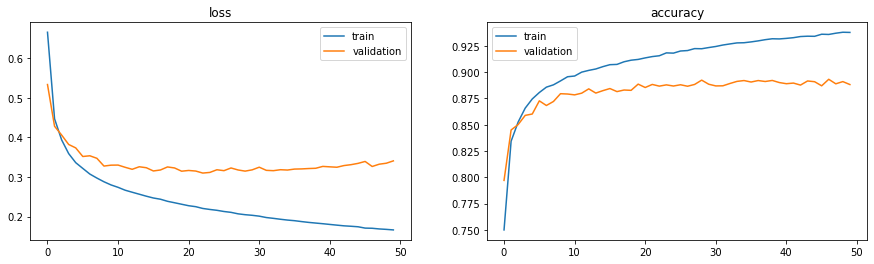

In [124]:
visualize(history_lnt)

### MiniVGGNet

In [79]:
%%time

init_lr = 1e-2
num_epochs = 25
opt = keras.optimizers.SGD(lr=init_lr, momentum=0.9, decay=init_lr / num_epochs)
minivgg.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history_vgg = minivgg.fit(x=train_images_norm, y=train_labels, validation_data=(test_images_norm, test_labels),
                          batch_size=32, epochs=num_epochs)

Epoch 1/25
1875/1875 [==============================] - 170s 91ms/step - loss: 0.5649 - accuracy: 0.8102 - val_loss: 0.3942 - val_accuracy: 0.8581
Epoch 2/25
1875/1875 [==============================] - 169s 90ms/step - loss: 0.3493 - accuracy: 0.8743 - val_loss: 0.2805 - val_accuracy: 0.8952
Epoch 3/25
1875/1875 [==============================] - 170s 91ms/step - loss: 0.2996 - accuracy: 0.8921 - val_loss: 0.8729 - val_accuracy: 0.8231
Epoch 4/25
1875/1875 [==============================] - 169s 90ms/step - loss: 0.2756 - accuracy: 0.9008 - val_loss: 0.2441 - val_accuracy: 0.9093
Epoch 5/25
1875/1875 [==============================] - 169s 90ms/step - loss: 0.2623 - accuracy: 0.9045 - val_loss: 0.2499 - val_accuracy: 0.9078
Epoch 6/25
1875/1875 [==============================] - 169s 90ms/step - loss: 0.2470 - accuracy: 0.9115 - val_loss: 0.2337 - val_accuracy: 0.9144
Epoch 7/25
1875/1875 [==============================] - 169s 90ms/step - loss: 0.2411 - accuracy: 0.9125 - val_loss: 0

(<Figure size 1080x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>], dtype=object))

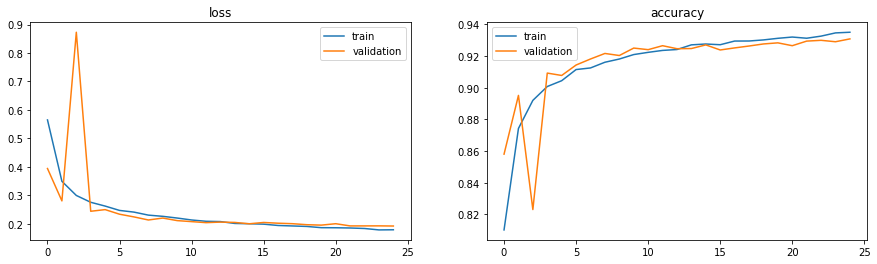

In [80]:
visualize(history_vgg)

### MobileNetV2

In [171]:
%%time

init_lr = 1e-2
num_epochs = 25
opt = keras.optimizers.SGD(lr=init_lr, momentum=0.9, decay=init_lr / num_epochs)
mobilenetv2.compile(optimizer=opt,
                    loss=keras.losses.sparse_categorical_crossentropy,
                    metrics=['accuracy'])

history_mob = mobilenetv2.fit(x=train_images_pad, y=train_labels, validation_data=(test_images_pad, test_labels),
                              batch_size = 32, verbose=1, epochs=num_epochs)

Epoch 1/25
1875/1875 [==============================] - 184s 98ms/step - loss: 0.6208 - accuracy: 0.7833 - val_loss: 2.5979 - val_accuracy: 0.1000
Epoch 2/25
1875/1875 [==============================] - 181s 97ms/step - loss: 0.3776 - accuracy: 0.8641 - val_loss: 2.2313 - val_accuracy: 0.2763
Epoch 3/25
1875/1875 [==============================] - 180s 96ms/step - loss: 0.3207 - accuracy: 0.8813 - val_loss: 0.5716 - val_accuracy: 0.8556
Epoch 4/25
1875/1875 [==============================] - 180s 96ms/step - loss: 0.2892 - accuracy: 0.8927 - val_loss: 0.3843 - val_accuracy: 0.8663
Epoch 5/25
1875/1875 [==============================] - 180s 96ms/step - loss: 0.2669 - accuracy: 0.9008 - val_loss: 0.3100 - val_accuracy: 0.8837
Epoch 6/25
1875/1875 [==============================] - 180s 96ms/step - loss: 0.2496 - accuracy: 0.9058 - val_loss: 0.3415 - val_accuracy: 0.8678
Epoch 7/25
1875/1875 [==============================] - 181s 97ms/step - loss: 0.2340 - accuracy: 0.9125 - val_loss: 0

(<Figure size 1080x288 with 2 Axes>,
 array([<AxesSubplot:title={'center':'loss'}>,
        <AxesSubplot:title={'center':'accuracy'}>], dtype=object))

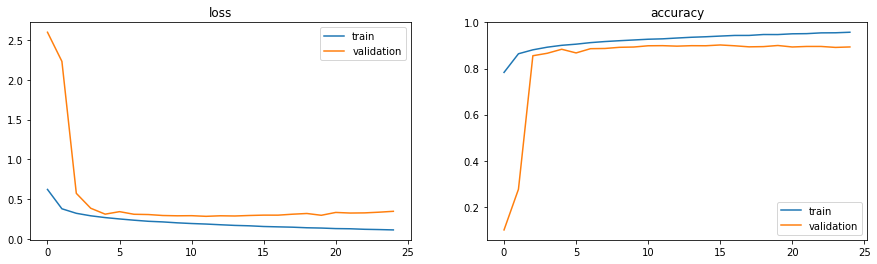

In [172]:
visualize(history_mob)

### Fashion MNist

In [138]:
df_fmnist = evaluate_dataset('fmnist', num_epochs=100)
df_fmnist.to_pickle('df_fmnist.pkl')
df_fmnist

Epoch 1/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.6234 - accuracy: 0.7678 - val_loss: 0.4382 - val_accuracy: 0.8365
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3879 - accuracy: 0.8568 - val_loss: 0.3834 - val_accuracy: 0.8621
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3359 - accuracy: 0.8736 - val_loss: 0.3339 - val_accuracy: 0.8781
Epoch 4/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3051 - accuracy: 0.8863 - val_loss: 0.3243 - val_accuracy: 0.8801
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2837 - accuracy: 0.8945 - val_loss: 0.3158 - val_accuracy: 0.8840
Epoch 6/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2678 - accuracy: 0.9004 - val_loss: 0.2921 - val_accuracy: 0.8942
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2554 - accuracy: 0.9033 - val_loss: 0.2896 - val_ac

Epoch 13/100
1875/1875 [==============================] - 224s 119ms/step - loss: 0.1755 - accuracy: 0.9359 - val_loss: 0.1959 - val_accuracy: 0.9256
Epoch 14/100
1875/1875 [==============================] - 223s 119ms/step - loss: 0.1709 - accuracy: 0.9381 - val_loss: 0.1853 - val_accuracy: 0.9322
Epoch 15/100
1875/1875 [==============================] - 223s 119ms/step - loss: 0.1646 - accuracy: 0.9395 - val_loss: 0.1985 - val_accuracy: 0.9274
Epoch 16/100
1875/1875 [==============================] - 223s 119ms/step - loss: 0.1599 - accuracy: 0.9413 - val_loss: 0.1866 - val_accuracy: 0.9335
Epoch 17/100
1875/1875 [==============================] - 223s 119ms/step - loss: 0.1563 - accuracy: 0.9430 - val_loss: 0.1813 - val_accuracy: 0.9367
Epoch 18/100
1875/1875 [==============================] - 223s 119ms/step - loss: 0.1490 - accuracy: 0.9457 - val_loss: 0.1827 - val_accuracy: 0.9308
Epoch 19/100
1875/1875 [==============================] - 224s 120ms/step - loss: 0.1474 - accuracy:

1875/1875 [==============================] - 180s 96ms/step - loss: 2.7035 - accuracy: 0.1000 - val_loss: 13.5972 - val_accuracy: 0.1000
Epoch 22/100
1875/1875 [==============================] - 181s 96ms/step - loss: 2.7027 - accuracy: 0.1000 - val_loss: 10.3874 - val_accuracy: 0.1000
Epoch 23/100
1875/1875 [==============================] - 180s 96ms/step - loss: 2.7075 - accuracy: 0.1000 - val_loss: 7.2328 - val_accuracy: 0.1000
Epoch 24/100
1875/1875 [==============================] - 180s 96ms/step - loss: 2.7085 - accuracy: 0.1000 - val_loss: 10.5077 - val_accuracy: 0.1000
Epoch 25/100
1875/1875 [==============================] - 180s 96ms/step - loss: 2.6996 - accuracy: 0.1000 - val_loss: 7.1735 - val_accuracy: 0.0999
Epoch 26/100
1875/1875 [==============================] - 179s 96ms/step - loss: 2.7009 - accuracy: 0.1000 - val_loss: 7.1470 - val_accuracy: 0.0999
Epoch 27/100
1875/1875 [==============================] - 180s 96ms/step - loss: 2.7049 - accuracy: 0.1000 - val_los

1875/1875 [==============================] - 179s 96ms/step - loss: 2.6033 - accuracy: 0.1000 - val_loss: 11.9861 - val_accuracy: 0.1000
Epoch 77/100
1875/1875 [==============================] - 179s 95ms/step - loss: 2.6034 - accuracy: 0.1000 - val_loss: 11.9861 - val_accuracy: 0.1000
Epoch 78/100
1875/1875 [==============================] - 179s 96ms/step - loss: 2.6043 - accuracy: 0.1000 - val_loss: 10.3751 - val_accuracy: 0.1000
Epoch 79/100
1875/1875 [==============================] - 179s 96ms/step - loss: 2.6037 - accuracy: 0.1000 - val_loss: 10.3751 - val_accuracy: 0.1000
Epoch 80/100
1875/1875 [==============================] - 179s 96ms/step - loss: 2.6035 - accuracy: 0.1000 - val_loss: 11.9861 - val_accuracy: 0.1000
Epoch 81/100
1875/1875 [==============================] - 180s 96ms/step - loss: 2.6038 - accuracy: 0.1000 - val_loss: 8.9795 - val_accuracy: 0.1000
Epoch 82/100
1875/1875 [==============================] - 180s 96ms/step - loss: 2.6036 - accuracy: 0.1000 - val_l

,name,shapey,shapex,shapez,train size,test size,num epochs,lenet runtime,lenet test err,lenet history,vgg runtime,vgg test err,vgg history,mobilenet runtime,mobilenet test err,mobilenet history
0,fmnist,32,32,1,60000,10000,100,874.162244,0.9081,<tensorflow.python.keras.callbacks.History obj...,22434.556872,0.9439,<tensorflow.python.keras.callbacks.History obj...,18079.152862,0.10003,<tensorflow.python.keras.callbacks.History obj...


In [172]:
df_fmnist

,name,shapey,shapex,shapez,train size,test size,num epochs,lenet runtime,lenet test err,lenet history,vgg runtime,vgg test err,vgg history,mobilenet runtime,mobilenet test err,mobilenet history,convsvm runtime,convsvm test err,convsvm history
0,fmnist,32,32,1,60000,10000,100,874.162244,0.9081,"{'loss': [0.6234489679336548, 0.38793143630027...",22434.556872,0.9439,"{'loss': [0.5175429582595825, 0.33762103319168...",18973.48017,0.9074,"{'loss': [0.6217073202133179, 0.38363438844680...",361.976835,0.8277,"{'accuracy': [0.8441833333333333], 'val_accura..."


### Cifar10

In [210]:
df_cifar = evaluate_dataset('cifar10', num_epochs=100)
df_cifar.to_pickle('df_cifar.pkl')
df_cifar

Epoch 1/100
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7826 - accuracy: 0.3506 - val_loss: 1.6145 - val_accuracy: 0.4213
Epoch 2/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4577 - accuracy: 0.4724 - val_loss: 1.3607 - val_accuracy: 0.5125
Epoch 3/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.3302 - accuracy: 0.5214 - val_loss: 1.3110 - val_accuracy: 0.5333
Epoch 4/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.2395 - accuracy: 0.5555 - val_loss: 1.2705 - val_accuracy: 0.5483
Epoch 5/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.1612 - accuracy: 0.5878 - val_loss: 1.2112 - val_accuracy: 0.5748
Epoch 6/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0941 - accuracy: 0.6116 - val_loss: 1.1771 - val_accuracy: 0.5871
Epoch 7/100
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0340 - accuracy: 0.6341 - val_loss: 1.1677 - val_a

Epoch 13/100
1563/1563 [==============================] - 191s 122ms/step - loss: 0.5253 - accuracy: 0.8157 - val_loss: 0.6075 - val_accuracy: 0.7911
Epoch 14/100
1563/1563 [==============================] - 191s 122ms/step - loss: 0.5025 - accuracy: 0.8239 - val_loss: 0.5680 - val_accuracy: 0.8053
Epoch 15/100
1563/1563 [==============================] - 191s 122ms/step - loss: 0.4846 - accuracy: 0.8308 - val_loss: 0.5618 - val_accuracy: 0.8067
Epoch 16/100
1563/1563 [==============================] - 191s 122ms/step - loss: 0.4675 - accuracy: 0.8377 - val_loss: 0.5615 - val_accuracy: 0.8123
Epoch 17/100
1563/1563 [==============================] - 191s 122ms/step - loss: 0.4556 - accuracy: 0.8390 - val_loss: 0.5749 - val_accuracy: 0.8039
Epoch 18/100
1563/1563 [==============================] - 192s 123ms/step - loss: 0.4365 - accuracy: 0.8462 - val_loss: 0.5493 - val_accuracy: 0.8127
Epoch 19/100
1563/1563 [==============================] - 192s 123ms/step - loss: 0.4232 - accuracy:

1563/1563 [==============================] - 157s 101ms/step - loss: 0.9360 - accuracy: 0.6665 - val_loss: 1.1483 - val_accuracy: 0.5895
Epoch 22/100
1563/1563 [==============================] - 158s 101ms/step - loss: 0.9268 - accuracy: 0.6716 - val_loss: 1.2183 - val_accuracy: 0.5699
Epoch 23/100
1563/1563 [==============================] - 157s 101ms/step - loss: 0.8985 - accuracy: 0.6806 - val_loss: 1.2263 - val_accuracy: 0.5654
Epoch 24/100
1563/1563 [==============================] - 158s 101ms/step - loss: 0.8522 - accuracy: 0.6952 - val_loss: 1.0877 - val_accuracy: 0.6147
Epoch 25/100
1563/1563 [==============================] - 158s 101ms/step - loss: 0.8982 - accuracy: 0.6784 - val_loss: 1.3152 - val_accuracy: 0.5516
Epoch 26/100
1563/1563 [==============================] - 157s 101ms/step - loss: 0.8705 - accuracy: 0.6873 - val_loss: 1.0746 - val_accuracy: 0.6217
Epoch 27/100
1563/1563 [==============================] - 157s 101ms/step - loss: 0.8617 - accuracy: 0.6951 - val

,name,shapey,shapex,shapez,train size,test size,num epochs,lenet runtime,lenet test err,lenet history,vgg runtime,vgg test err,vgg history,mobilenet runtime,mobilenet test err,mobilenet history
0,cifar10,32,32,3,50000,10000,100,905.454609,0.5862,"{'loss': [1.7826309204101562, 1.45772171020507...",19137.917245,0.8348,"{'loss': [1.8757611513137817, 1.21302139759063...",15757.714642,0.6534,"{'loss': [2.3537964820861816, 1.81646561622619..."


In [31]:
df_cifar

,name,shapey,shapex,shapez,train size,test size,num epochs,lenet runtime,lenet test err,lenet history,vgg runtime,vgg test err,vgg history,mobilenet runtime,mobilenet test err,mobilenet history,convsvm runtime,convsvm test err,convsvm history
0,cifar10,32,32,3,50000,10000,100,905.454609,0.5862,"{'loss': [1.7826309204101562, 1.45772171020507...",19137.917245,0.8348,"{'loss': [1.8757611513137817, 1.21302139759063...",15757.714642,0.6534,"{'loss': [2.3537964820861816, 1.81646561622619...",842.1628,0.3582,"{'accuracy': [0.44272], 'val_accuracy': [0.3582]}"


### Breast Cancer

In [26]:
data = (bc_train_x,bc_train_y,bc_test_x,bc_test_y)
df_bc = evaluate_dataset(data, num_epochs=100)
df_bc.to_pickle('df_bcancer.pkl')
df_bc

Epoch 1/100
1240/1240 [==============================] - 15s 12ms/step - loss: 0.4967 - accuracy: 0.7750 - val_loss: 0.4111 - val_accuracy: 0.8220
Epoch 2/100
1240/1240 [==============================] - 16s 13ms/step - loss: 0.4188 - accuracy: 0.8212 - val_loss: 0.4925 - val_accuracy: 0.7920
Epoch 3/100
1240/1240 [==============================] - 15s 12ms/step - loss: 0.4071 - accuracy: 0.8244 - val_loss: 0.3912 - val_accuracy: 0.8287
Epoch 4/100
1240/1240 [==============================] - 15s 12ms/step - loss: 0.3944 - accuracy: 0.8299 - val_loss: 0.4040 - val_accuracy: 0.8223
Epoch 5/100
1240/1240 [==============================] - 15s 12ms/step - loss: 0.3890 - accuracy: 0.8336 - val_loss: 0.3970 - val_accuracy: 0.8272
Epoch 6/100
1240/1240 [==============================] - 16s 13ms/step - loss: 0.3783 - accuracy: 0.8382 - val_loss: 0.3813 - val_accuracy: 0.8344
Epoch 7/100
1240/1240 [==============================] - 15s 12ms/step - loss: 0.3716 - accuracy: 0.8437 - val_loss: 0

1240/1240 [==============================] - 322s 260ms/step - loss: 0.3358 - accuracy: 0.8582 - val_loss: 0.5449 - val_accuracy: 0.8123
Epoch 11/100
1240/1240 [==============================] - 320s 258ms/step - loss: 0.3295 - accuracy: 0.8604 - val_loss: 1.1781 - val_accuracy: 0.7807
Epoch 12/100
1240/1240 [==============================] - 322s 260ms/step - loss: 0.3256 - accuracy: 0.8633 - val_loss: 0.3690 - val_accuracy: 0.8505
Epoch 13/100
1240/1240 [==============================] - 325s 262ms/step - loss: 0.3189 - accuracy: 0.8649 - val_loss: 0.3324 - val_accuracy: 0.8577
Epoch 14/100
1240/1240 [==============================] - 322s 260ms/step - loss: 0.3219 - accuracy: 0.8629 - val_loss: 0.3246 - val_accuracy: 0.8652
Epoch 15/100
1240/1240 [==============================] - 322s 260ms/step - loss: 0.3165 - accuracy: 0.8661 - val_loss: 0.3586 - val_accuracy: 0.8612
Epoch 16/100
1240/1240 [==============================] - 324s 261ms/step - loss: 0.3126 - accuracy: 0.8676 - val

Epoch 65/100
1240/1240 [==============================] - 319s 258ms/step - loss: 0.2263 - accuracy: 0.9055 - val_loss: 0.3258 - val_accuracy: 0.8672
Epoch 66/100
1240/1240 [==============================] - 320s 258ms/step - loss: 0.2245 - accuracy: 0.9079 - val_loss: 0.3601 - val_accuracy: 0.8514
Epoch 67/100
1240/1240 [==============================] - 320s 258ms/step - loss: 0.2221 - accuracy: 0.9062 - val_loss: 0.3637 - val_accuracy: 0.8588
Epoch 68/100
1240/1240 [==============================] - 320s 258ms/step - loss: 0.2224 - accuracy: 0.9084 - val_loss: 0.3780 - val_accuracy: 0.8446
Epoch 69/100
1240/1240 [==============================] - 320s 258ms/step - loss: 0.2156 - accuracy: 0.9077 - val_loss: 0.3507 - val_accuracy: 0.8684
Epoch 70/100
1240/1240 [==============================] - 321s 259ms/step - loss: 0.2171 - accuracy: 0.9101 - val_loss: 0.3189 - val_accuracy: 0.8702
Epoch 71/100
1240/1240 [==============================] - 320s 258ms/step - loss: 0.2144 - accuracy:

Epoch 74/100
1240/1240 [==============================] - 281s 227ms/step - loss: 0.0103 - accuracy: 0.9967 - val_loss: 0.9624 - val_accuracy: 0.8378
Epoch 75/100
1240/1240 [==============================] - 282s 228ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.9725 - val_accuracy: 0.8366
Epoch 76/100
1240/1240 [==============================] - 283s 228ms/step - loss: 0.0101 - accuracy: 0.9967 - val_loss: 1.0948 - val_accuracy: 0.8000
Epoch 77/100
1240/1240 [==============================] - 282s 228ms/step - loss: 0.0094 - accuracy: 0.9968 - val_loss: 1.0259 - val_accuracy: 0.8417
Epoch 78/100
1240/1240 [==============================] - 283s 228ms/step - loss: 0.0104 - accuracy: 0.9963 - val_loss: 0.9650 - val_accuracy: 0.8330
Epoch 79/100
1240/1240 [==============================] - 282s 228ms/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 1.0221 - val_accuracy: 0.8357
Epoch 80/100
1240/1240 [==============================] - 282s 228ms/step - loss: 0.0077 - accuracy:

,name,shapey,shapex,shapez,train size,test size,num epochs,lenet runtime,lenet test err,lenet history,vgg runtime,vgg test err,vgg history,mobilenet runtime,mobilenet test err,mobilenet history
0,([[[[0.7764706 0.41960785 0.50196081]\n [0.77...,50,50,3,39652,9913,100,1562.525208,0.815898,"{'loss': [0.4966748356819153, 0.41883975267410...",32099.639098,0.874609,"{'loss': [0.7388870120048523, 0.47940790653228...",28348.39738,0.823061,"{'loss': [0.4183903932571411, 0.36975672841072..."


In [73]:
df_bc

,name,shapey,shapex,shapez,train size,test size,num epochs,lenet runtime,lenet test err,lenet history,vgg runtime,vgg test err,vgg history,mobilenet runtime,mobilenet test err,mobilenet history,convsvm runtime,convsvm test err,convsvm history
0,([[[[0.7764706 0.41960785 0.50196081]\n [0.77...,50,50,3,39652,9913,100,1562.525208,0.815898,"{'loss': [0.4966748356819153, 0.41883975267410...",32099.639098,0.874609,"{'loss': [0.7388870120048523, 0.47940790653228...",28348.39738,0.823061,"{'loss': [0.4183903932571411, 0.36975672841072...",306.520446,0.761122,"{'accuracy': [0.7646020377282357], 'val_accura..."


### Combine All

In [10]:
df_bc = pd.read_pickle('df_bcancer.pkl')
df_bc['name'] = 'bcancer'
df_bc

KeyboardInterrupt: 

In [ ]:
df_bc.to_pickle('df_bcancer.pkl')

In [11]:
df_bc['name'] = 'bcancer'
df_bc

,name,shapey,shapex,shapez,train size,test size,num epochs,lenet runtime,lenet test err,lenet history,vgg runtime,vgg test err,vgg history,mobilenet runtime,mobilenet test err,mobilenet history,convsvm runtime,convsvm test err,convsvm history
0,bcancer,50,50,3,39652,9913,100,1562.525208,0.815898,"{'loss': [0.4966748356819153, 0.41883975267410...",32099.639098,0.874609,"{'loss': [0.7388870120048523, 0.47940790653228...",28348.39738,0.823061,"{'loss': [0.4183903932571411, 0.36975672841072...",306.520446,0.761122,"{'accuracy': [0.7646020377282357], 'val_accura..."


In [75]:
# Load if needed
df_fmnist = pd.read_pickle('df_fmnist.pkl')
df_cifar = pd.read_pickle('df_cifar.pkl')
df_bc = pd.read_pickle('df_bcancer.pkl')

In [76]:
df = pd.concat([df_fmnist, df_cifar, df_bc])
df

,name,shapey,shapex,shapez,train size,test size,num epochs,lenet runtime,lenet test err,lenet history,vgg runtime,vgg test err,vgg history,mobilenet runtime,mobilenet test err,mobilenet history,convsvm runtime,convsvm test err,convsvm history
0,fmnist,32,32,1,60000,10000,100,874.162244,0.908100,"{'loss': [0.6234489679336548, 0.38793143630027...",22434.556872,0.943900,"{'loss': [0.5175429582595825, 0.33762103319168...",18973.480170,0.907400,"{'loss': [0.6217073202133179, 0.38363438844680...",361.976835,0.827700,"{'accuracy': [0.8441833333333333], 'val_accura..."
0,cifar10,32,32,3,50000,10000,100,905.454609,0.586200,"{'loss': [1.7826309204101562, 1.45772171020507...",19137.917245,0.834800,"{'loss': [1.8757611513137817, 1.21302139759063...",15757.714642,0.653400,"{'loss': [2.3537964820861816, 1.81646561622619...",842.162800,0.358200,"{'accuracy': [0.44272], 'val_accuracy': [0.3582]}"
0,([[[[0.7764706 0.41960785 0.50196081]\n [0.77...,50,50,3,39652,9913,100,1562.525208,0.815898,"{'loss': [0.4966748356819153, 0.41883975267410...",32099.639098,0.874609,"{'loss': [0.7388870120048523, 0.47940790653228...",28348.397380,0.823061,"{'loss': [0.4183903932571411, 0.36975672841072...",306.520446,0.761122,"{'accuracy': [0.7646020377282357], 'val_accura..."


Text(0.5, 1.0, 'Runtime of Different Datasets using Different Models')

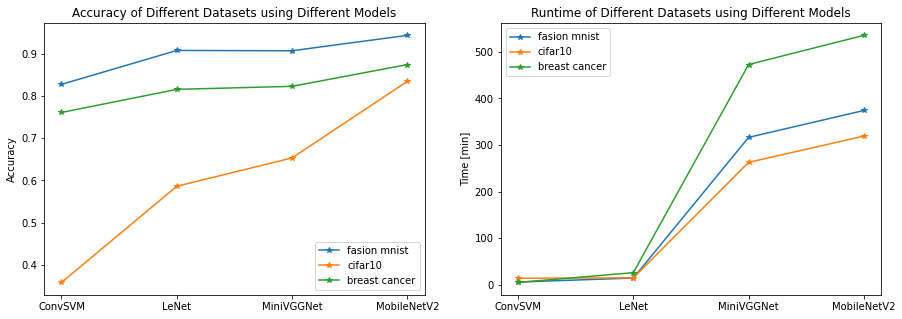

In [78]:
# plot accuracy
data_err = df[['convsvm test err', 'lenet test err', 'mobilenet test err', 'vgg test err']].to_numpy()
data_time = df[['convsvm runtime', 'lenet runtime', 'mobilenet runtime', 'vgg runtime']].to_numpy() / 60

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(data_err.T,'-*')
plt.legend(['fasion mnist', 'cifar10', 'breast cancer'])
plt.xticks(np.arange(4), ['ConvSVM', 'LeNet', 'MiniVGGNet', 'MobileNetV2'])
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Datasets using Different Models')

plt.subplot(1,2,2)
plt.plot(data_time.T,'-*')
plt.legend(['fasion mnist', 'cifar10', 'breast cancer'])
plt.xticks(np.arange(4), ['ConvSVM', 'LeNet', 'MiniVGGNet', 'MobileNetV2'])
plt.ylabel('Time [min]')
plt.title('Runtime of Different Datasets using Different Models')